In [1]:
import pandas as pd
from datetime import datetime
import ta

def send_order(market='upbit',order_type='buy', quantity=1, target_date="2018-10-11", krw_balance = 0.0, btc_balance=0.0 ):
    
    bitcoin_dt = pd.read_csv('upbit_krwbtc_1day.csv')
    
    target_date = datetime.strptime(target_date,"%Y-%m-%d")
    
    price = -1
    
    dt_index=0
    
    
    
    for index, bitcoin in bitcoin_dt.iterrows():
        temp = datetime.strptime(bitcoin['timestamp'][:10],"%Y-%m-%d")
        if temp == target_date:
            price = float(bitcoin['close'])
            dt_index=index
            break;
    
    total_balance = krw_balance + (btc_balance)*float(bitcoin['close'])
            
    if order_type == 'buy':
        if (price*quantity) <= krw_balance:
            krw_balance = krw_balance - (price * quantity)
            btc_balance = btc_balance + quantity
            total_balance = krw_balance + (btc_balance)*float(bitcoin['close'])
            print("주문 성공 : 구매 ({}) -  btckrw:{} 수량:{} 원화잔고:{} 비트코인잔고:{} 평가금액 :{}\\".
                  format(bitcoin_dt['timestamp'][dt_index],
                         float(bitcoin['close']),
                         quantity,
                         krw_balance,
                         btc_balance,
                         krw_balance + (btc_balance)*float(bitcoin['close'])))
        else:
            print("주문실패 : 잔고부족 ({})".format(bitcoin_dt['timestamp'][dt_index]))
            
    elif order_type == 'sell':
        if quantity <= btc_balance:
            krw_balance = krw_balance + (price * quantity)
            btc_balance = btc_balance - quantity
            total_balance = krw_balance + (btc_balance)*float(bitcoin['close'])
            print("주문 성공 : 판매 ({}) -  btckrw:{} 수량:{} 원화잔고:{} 비트코인잔고:{} 평가금액: {}\\".
                  format(bitcoin_dt['timestamp'][dt_index],
                         float(bitcoin['close']),
                         quantity,krw_balance,
                         btc_balance,
                         krw_balance + (btc_balance)*float(bitcoin['close'])))
        else:
            print("주문실패 : 잔고부족 ({})".format(bitcoin_dt['timestamp'][dt_index]))
    
    return krw_balance, btc_balance, total_balance

def execute_backtest(init_krw_bal = 100000000, init_btc_bal = 0, order_quantity = 5,
                    date_list=['2019-01-11','2019-02-11','2019-02-20','2019-06-11','2019-07-11','2019-07-20'],
                    type_list=['buy','buy','buy','sell','sell','sell'] ):

    krw_bal = init_krw_bal
    btc_bal = init_btc_bal
    total_bal = 0;
    order_quantity = order_quantity

    date_list= date_list
    type_list= type_list
    list_len = len(date_list)
    
    krw_bal_list = []
    btc_bal_list = []
    balance_list = []

    print("현재 원화잔고 : {}\\".format(krw_bal))
    print("현재 비트코인잔고 : {}".format(btc_bal))

    for i in range(list_len):
        krw_bal, btc_bal, total_bal = send_order(market='upbit',
                                                  order_type=type_list[i],
                                                  quantity= order_quantity,
                                                  target_date=date_list[i],
                                                  krw_balance = krw_bal,
                                                  btc_balance=btc_bal)
        krw_bal_list.append(krw_bal)
        btc_bal_list.append(btc_bal)
        balance_list.append(total_bal)

    print("현재 원화잔고 : {}\\".format(krw_bal))
    print("현재 비트코인잔고 : {}".format(btc_bal))
    print("수익률 : {}%".format( (total_bal-init_krw_bal)/init_krw_bal*100))
    
    return krw_bal, btc_bal, balance_list
    

def macd():
    bitcoin_dt = pd.read_csv('upbit_krwbtc_1day.csv')
    df = bitcoin_dt
    macd = ta.trend.MACD(bitcoin_dt['close'])
    indicator_macd = ta.trend.MACD(df['close'])
    # Add Bollinger Bands features
    df['macd'] = indicator_macd.macd()
    df['macd_diff'] = indicator_macd.macd_diff()
    df['macd_signal'] = indicator_macd.macd_signal()
    date_list=[]
    type_list=[]

    for index, data in df.iterrows():
        if str(data['macd']) != 'nan':
            if df['macd'][index-1] * data['macd'] < 0:
                if data['macd']<0:
                    #print("sell : {},{}".format(data['macd'],data['timestamp']))
                    date_list.append(data['timestamp'][:10])
                    type_list.append("sell")
                else:
                    #print("buy : {},{}".format(data['macd'],data['timestamp']))
                    date_list.append(data['timestamp'][:10])
                    type_list.append("buy")

    return date_list, type_list
    

In [2]:
date_list, type_list = macd()
krw_bal,btc_bal,t = execute_backtest(init_krw_bal=100000000, order_quantity=10, date_list=date_list,type_list= type_list)

현재 원화잔고 : 100000000\
현재 비트코인잔고 : 0
주문실패 : 잔고부족 (2018-01-16T09:00:00)
주문실패 : 잔고부족 (2018-03-02T09:00:00)
주문실패 : 잔고부족 (2018-03-08T09:00:00)
주문 성공 : 구매 (2018-04-20T09:00:00) -  btckrw:9552000.0 수량:10 원화잔고:4480000.0 비트코인잔고:10 평가금액 :100000000.0\
주문 성공 : 판매 (2018-05-17T09:00:00) -  btckrw:9090000.0 수량:10 원화잔고:95380000.0 비트코인잔고:0 평가금액: 95380000.0\
주문 성공 : 구매 (2018-07-17T09:00:00) -  btckrw:8080000.0 수량:10 원화잔고:14580000.0 비트코인잔고:10 평가금액 :95380000.0\
주문 성공 : 판매 (2018-08-08T09:00:00) -  btckrw:7308000.0 수량:10 원화잔고:87660000.0 비트코인잔고:0 평가금액: 87660000.0\
주문 성공 : 구매 (2018-09-01T09:00:00) -  btckrw:8001000.0 수량:10 원화잔고:7650000.0 비트코인잔고:10 평가금액 :87660000.0\
주문 성공 : 판매 (2018-09-08T09:00:00) -  btckrw:7206000.0 수량:10 원화잔고:79710000.0 비트코인잔고:0 평가금액: 79710000.0\
주문 성공 : 구매 (2018-10-08T09:00:00) -  btckrw:7542000.0 수량:10 원화잔고:4290000.0 비트코인잔고:10 평가금액 :79710000.0\
주문 성공 : 판매 (2018-10-11T09:00:00) -  btckrw:7187000.0 수량:10 원화잔고:76160000.0 비트코인잔고:0 평가금액: 76160000.0\
주문 성공 : 구매 (2019-01-08T09:00:00) -  btckrw:44

In [31]:
tmp = pd.read_csv('upbit_krwbtc_1day.csv')
tmp

,timestamp,open,close,high,low,volume
0,2017-09-25T09:00:00,4201000.0,4322000.0,4333000.0,4175000.0,132.484755
1,2017-09-26T09:00:00,4317000.0,4321000.0,4418000.0,4311000.0,22.788340
2,2017-09-27T09:00:00,4322000.0,4657000.0,4677000.0,4318000.0,32.269662
3,2017-09-28T09:00:00,4657000.0,4586000.0,4772000.0,4519000.0,80.588243
4,2017-09-29T09:00:00,4586000.0,4657000.0,4709000.0,4476000.0,59.352373
...,...,...,...,...,...,...
914,2020-03-27T09:00:00,8281000.0,7880000.0,8365000.0,7820000.0,6749.553055
915,2020-03-28T09:00:00,7883000.0,7656000.0,7885000.0,7403000.0,7702.102337
916,2020-03-29T09:00:00,7658000.0,7218000.0,7679000.0,7215000.0,4443.497879
917,2020-03-30T09:00:00,7218000.0,7798000.0,8014000.0,7199000.0,9173.560851


In [32]:
tmps = tmp['timestamp'].tolist()
timestamps= []
for timestamp in tmps:
    timestamps.append(timestamp[:10])

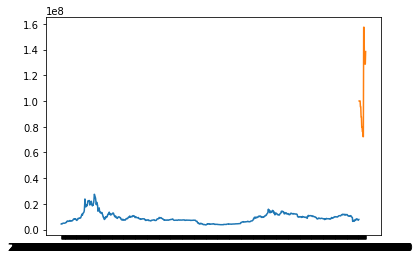

In [11]:
import matplotlib.pyplot as plt

plt.plot(tmp['timestamp'],tmp['close'],date_list,t)

In [37]:
balance_list = []
init_bal = 100000000
for i in range(len(timestamps)):
    balance_list.append(init_bal)
    
for i in range(len(timestamps)):
    check = 0
    for j in range(len(date_list)):
        if timestamps[i] == date_list[j]:
            for k in range(i,len(timestamps)):
                balance_list[k] = t[j]


In [49]:
interest_list=[]
for balance in balance_list:
    interest_list.append( (balance-init_bal)/init_bal * 100)

In [50]:
interest_list

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

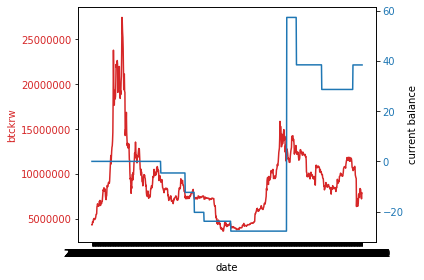

In [51]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('btckrw',color=color)
ax1.plot(timestamps,tmp['close'],color=color)
ax1.tick_params(axis='y',labelcolor=color)
ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
plt.ticklabel_format(style='plain', axis='y')

ax2 = ax1.twinx()

color = "tab:blue"
ax2.set_ylabel('수익률')
ax2.plot(timestamps, interest_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [12]:
tmp = pd.read_csv('upbit_krwbtc_1day.csv', index_col='timestamp')
df = ta.add_all_ta_features(
    tmp, open="open", high="high", low="low", close="close", volume="volume")

C:\Users\KOSCOM\Anaconda3\lib\site-packages\ta\trend.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
C:\Users\KOSCOM\Anaconda3\lib\site-packages\ta\trend.py:547: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [16]:
df['trend_macd'].tail(100)

timestamp
2019-12-23T09:00:00   -165520.389378
2019-12-24T09:00:00   -149108.845522
2019-12-25T09:00:00   -142528.760215
2019-12-26T09:00:00   -135669.391269
2019-12-27T09:00:00   -127632.342764
                           ...      
2020-03-27T09:00:00   -509868.155200
2020-03-28T09:00:00   -496793.078028
2020-03-29T09:00:00   -515827.783059
2020-03-30T09:00:00   -478594.827934
2020-03-31T09:00:00   -439422.628587
Name: trend_macd, Length: 100, dtype: float64

In [163]:
indicator_macd = ta.trend.MACD(df['close'])

In [164]:
# Add Bollinger Bands features
df['macd'] = indicator_macd.macd()
df['macd_diff'] = indicator_macd.macd_diff()
df['macd_signal'] = indicator_macd.macd_signal()

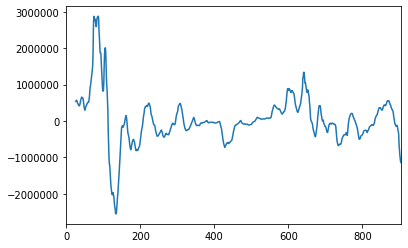

In [200]:
df['macd'].plot()

In [17]:
df['macd_signal'].plot()

KeyError: 'macd_signal'

In [171]:
df

,timestamp,open,close,high,low,volume,macd,macd_diff,macd_signal
0,2017-09-25T09:00:00,4201000.0,4322000.0,4333000.0,4175000.0,132.484755,NaN,NaN,NaN
1,2017-09-26T09:00:00,4317000.0,4321000.0,4418000.0,4311000.0,22.788340,NaN,NaN,NaN
2,2017-09-27T09:00:00,4322000.0,4657000.0,4677000.0,4318000.0,32.269662,NaN,NaN,NaN
3,2017-09-28T09:00:00,4657000.0,4586000.0,4772000.0,4519000.0,80.588243,NaN,NaN,NaN
4,2017-09-29T09:00:00,4586000.0,4657000.0,4709000.0,4476000.0,59.352373,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
901,2020-03-14T09:00:00,7261000.0,6823000.0,7284000.0,6600000.0,12799.582205,-9.087010e+05,-424991.479467,-483709.495249
902,2020-03-15T09:00:00,6823000.0,6909000.0,7298000.0,6660000.0,10779.970084,-9.996996e+05,-412792.047914,-586907.507227
903,2020-03-16T09:00:00,6905000.0,6385000.0,6914000.0,6000000.0,19383.807849,-1.101403e+06,-411596.171429,-689806.550084
904,2020-03-17T09:00:00,6385000.0,6774000.0,6885000.0,6280000.0,14938.329466,-1.137502e+06,-358156.161910,-779345.590562


In [193]:
date_list=[]
type_list=[]

for index, data in df.iterrows():
    if str(data['macd']) != 'nan':
        if df['macd'][index-1] * data['macd'] < 0:
            if data['macd']<0:
                print("sell : {},{}".format(data['macd'],data['timestamp']))
                date_list.append(data['timestamp'][:10])
                type_list.append("sell")
            else:
                print("buy : {},{}".format(data['macd'],data['timestamp']))
                date_list.append(data['timestamp'][:10])
                type_list.append("buy")


sell : -296984.1885231398,2018-01-16T09:00:00
buy : 607.17467732355,2018-03-02T09:00:00
sell : -91614.19833096862,2018-03-08T09:00:00
buy : 12853.143007135019,2018-04-20T09:00:00
sell : -26272.22668839805,2018-05-17T09:00:00
buy : 1924.1937058260664,2018-07-17T09:00:00
sell : -41630.25536519103,2018-08-08T09:00:00
buy : 16734.457010528073,2018-09-01T09:00:00
sell : -40445.322080205195,2018-09-08T09:00:00
buy : 6007.915969341062,2018-10-08T09:00:00
sell : -11460.715978840366,2018-10-11T09:00:00
buy : 7400.2726686205715,2019-01-08T09:00:00
sell : -9893.26186533086,2019-01-10T09:00:00
buy : 1879.582263130229,2019-02-17T09:00:00
sell : -14818.232243638486,2019-07-19T09:00:00
buy : 79177.05759454332,2019-08-05T09:00:00
sell : -27544.380923382938,2019-08-21T09:00:00
buy : 65414.972044635564,2019-10-29T09:00:00
sell : -33965.69213083759,2019-11-15T09:00:00
buy : 51265.44280757569,2020-01-07T09:00:00
sell : -30979.783454496413,2020-02-29T09:00:00


['2018-01-16',
 '2018-03-02',
 '2018-03-08',
 '2018-04-20',
 '2018-05-17',
 '2018-07-17',
 '2018-08-08',
 '2018-09-01',
 '2018-09-08',
 '2018-10-08',
 '2018-10-11',
 '2019-01-08',
 '2019-01-10',
 '2019-02-17',
 '2019-07-19',
 '2019-08-05',
 '2019-08-21',
 '2019-10-29',
 '2019-11-15',
 '2020-01-07',
 '2020-02-29']

In [199]:
init_krw_bal = 100000000

krw_bal = init_krw_bal
btc_bal = 0

order_quantity = 10


print("현재 원화잔고 : {}\\".format(krw_bal))
print("현재 비트코인잔고 : {}".format(btc_bal))

for i in range(len(date_list)):
    krw_bal, btc_bal = send_order(market='upbit',
                                  order_type=type_list[i],
                                  quantity= order_quantity,
                                  target_date=date_list[i],
                                  krw_balance = krw_bal,
                                  btc_balance=btc_bal)
    
print("현재 원화잔고 : {}\\".format(krw_bal))
print("현재 비트코인잔고 : {}".format(btc_bal))
print("수익률 : {}%".format( (krw_bal-init_krw_bal)/init_krw_bal*100))

현재 원화잔고 : 100000000\
현재 비트코인잔고 : 0
주문실패 : 잔고부족
주문실패 : 잔고부족
주문실패 : 잔고부족
주문 성공 : 구매 -  btckrw:9552000.0 수량:10 원화잔고:4480000.0 비트코인잔고:10
주문 성공 : 판매 -  btckrw:9090000.0 수량:10 원화잔고:95380000.0 비트코인잔고:0
주문 성공 : 구매 -  btckrw:8080000.0 수량:10 원화잔고:14580000.0 비트코인잔고:10
주문 성공 : 판매 -  btckrw:7308000.0 수량:10 원화잔고:87660000.0 비트코인잔고:0
주문 성공 : 구매 -  btckrw:8001000.0 수량:10 원화잔고:7650000.0 비트코인잔고:10
주문 성공 : 판매 -  btckrw:7206000.0 수량:10 원화잔고:79710000.0 비트코인잔고:0
주문 성공 : 구매 -  btckrw:7542000.0 수량:10 원화잔고:4290000.0 비트코인잔고:10
주문 성공 : 판매 -  btckrw:7187000.0 수량:10 원화잔고:76160000.0 비트코인잔고:0
주문 성공 : 구매 -  btckrw:4480000.0 수량:10 원화잔고:31360000.0 비트코인잔고:10
주문 성공 : 판매 -  btckrw:4087000.0 수량:10 원화잔고:72230000.0 비트코인잔고:0
주문 성공 : 구매 -  btckrw:4040000.0 수량:10 원화잔고:31830000.0 비트코인잔고:10
주문 성공 : 판매 -  btckrw:12549000.0 수량:10 원화잔고:157320000.0 비트코인잔고:0
주문 성공 : 구매 -  btckrw:14181000.0 수량:10 원화잔고:15510000.0 비트코인잔고:10
주문 성공 : 판매 -  btckrw:12293000.0 수량:10 원화잔고:138440000.0 비트코인잔고:0
주문 성공 : 구매 -  btckrw:10894000.0 수량:10 원화잔고:29500000.